In [7]:
import sys
import io
import os
import datetime

import requests
import json
import xml.etree.ElementTree as ET
import seaborn as sns

import pandas as pd
import numpy as np
import os
#os.chdir(workingDir)
import collections
import matplotlib
import io
import sys
import operator

import nbformat as nbf
from IPython.core.display import HTML
from IPython.display import display
from ipywidgets import interact, interactive,fixed
from IPython.display import Javascript, display,HTML
from ipywidgets import widgets, VBox
import ipywidgets
import IPython
from IPython.display import clear_output
import scipy.stats as stats
from statsmodels.graphics.mosaicplot import mosaic
import statsmodels.api as sm
from statsmodels.formula.api import ols
import os
import errno
import seaborn as sns
from string import Template
from functools import partial
from collections import OrderedDict

# Utility Classes
from modules.ConfUtility import * 
from modules.ReportGeneration import *
from modules.UniVarAnalytics import *
from modules.MultiVarAnalytics import *

In [2]:
workingDir = 'C:\\Users\hauretouze_m\\source\\repos\\MA Analysis\\Azure-TDSP-Utilities\\DataScienceUtilities\\DataReport-Utils\\Python'
export_dir = "C:\\Users\\hauretouze_m\\source\\repos\\MA Analysis\\Download_toolpiq\\export"

In [3]:
if not os.path.exists(export_dir):
    os.makedirs(export_dir)
    
def gen_report(conf_md,conf_code, md, code, filename):
    ReportGeneration.write_report(conf_md, conf_code, md, code, report_name=filename)

def translate_code_commands(cell, exported_cols, composite=False):    
    new_code_store = []
    exported_cols = [each for each in exported_cols if each!='']   
    for each in exported_cols:       
        w,x,y = each.split(',')
        with open('log.txt','w') as fout:
            fout.write('Processing call for the column {}'.format(each))
        temp=cell[0]

        new_line = temp.replace('interactive','apply').replace(
            "df=fixed(df)","df").replace("filename=fixed(filename)","'"+ReportMagic.var_files+"'").replace(
            "col1=w1","'"+w+"'").replace("col2=w2","'"+x+"'").replace("col3=w3","'"+y+"'").replace(
            "col3=fixed(w3)","'"+y+"'").replace(
            "Export=w_export","False").replace("conf_dict=fixed(conf_dict)","conf_dict")       
        new_line = new_line.replace("df,","[df,")
        new_line = new_line[:len(new_line)-1]+"])"
        new_line = new_line.replace("apply(","").replace(", [", "(*[")
        new_code_store.append(new_line)        
    return new_code_store

def add_to_report(section='', task=''):
    print ('Section {}, Task {} added for report generation'.format(section ,task))

def trigger_report(widgets,export_cols_file, output_report, no_widgets=1, md_text=''):
    exported_cols = []
    with open(export_cols_file,'r') as fin:
        for each in fin:
            each = each.strip()
            if each and not each.isspace():
                exported_cols.append(each)
                
    exported_cols = list(set(exported_cols))
    conf_md, conf_code, md, code=%show_report 
    md = md_text
    cell = code
    new_code_store = translate_code_commands(cell,exported_cols)
    gen_report(conf_md,conf_code, md, new_code_store, filename=export_dir+output_report)
    
def silentremove(filename):
    try:
        os.remove(filename)
    except OSError as e: # this would be "except OSError, e:" before Python 2.6
        if e.errno != errno.ENOENT: # errno.ENOENT = no such file or directory
            raise # re-raise exception if a different error occured

def handle_change(value):
    w_export.value=False

def getWidgetValue(w):
    w_value = ''
    try:
        w_value = w.value
    except:
        pass    
    return w_value

def handle_export(widget, w1, w2, w3, export_filename='temp.ipynb',md_text=''):    
    print ('Export is successful!')
    w1_value, w2_value, w3_value = \
        getWidgetValue(w1),getWidgetValue(w2),getWidgetValue(w3)
    st = ','.join(str(each) for each in [w1_value, w2_value, w3_value])
    with open(filename,'a') as fout:
        fout.write(st+'\n')
    trigger_report(w1_value, filename, export_filename, False, md_text=md_text)
    
def monthdelta(date, delta):
    m, y = (date.month+delta) % 12, date.year + ((date.month)+delta-1) // 12
    if not m: m = 12
    d = min(date.day, [31,
        29 if y%4==0 and not y%400==0 else 28,31,30,31,30,31,31,30,31,30,31][m-1])
    return date.replace(day=d,month=m, year=y)

In [4]:
url = "https://toolpiq.fr/ChargerCourbe.asmx/Charger"



now = datetime.datetime.now()
onMonthAgo = monthdelta(now, -1)

payload = {'typeAppel': '1',
           'usrLogin': "tran_r",
           'usrMdp': "Salomonst21!",
           'crbId': 0,
           'carId': '5',
           'pdlId': '0',
           'PfmPrev':'0',
           'apcType':'0',
           'pas':'1',
           'startEnd':'0',
           'avecChgtHeure':'0',
           'debut':onMonthAgo.strftime('%Y-%m-%d'),
           'fin':now.strftime('%Y-%m-%d')}

In [8]:
'''Read the collection of curve names and ids that interst us'''
xls = pd.ExcelFile('crb_id.xlsx')
df = xls.parse('Name_ID', na_values=['NA'])
df

,Nom de courbe,id
0,Prix de règlement des écarts négatifs,201
1,Prix de règlement des écarts positifs,200
2,Spot ELEC Germany,2062246
3,Spot ELEC France,93381
4,Prix Moyen Pondéré à la hausse,2699871
5,Prix Moyen Pondéré à la baisse,2699873
6,Prix Marginal à la hausse,2699872
7,Prix Marginal à la baisse,2699874
8,Tendance,2699870
9,Spot GAZ PEGS,2194379


In [9]:
'''Download the data from the API'''
values_df = pd.DataFrame()

for crb in range(df.shape[0]):
    payload["crbId"] = int(df.get_value(crb, 'id', takeable=False))
    
    # Do the request to the API
    response = requests.get(url, params=payload)
    #print(response.url)
    
    # Extract the strig from the response as an xml string and then get a json
    xmlRoot = ET.fromstring(response.text)
    j = json.loads(xmlRoot.text)
    
    doc_df = pd.DataFrame.from_dict(j)
    [doc_df[tag].replace('', np.nan, inplace=True) for tag in j]
    #values_df = values_df.add(doc_df)
    
    # Manage the non integrity of data concat
    try:
        values_df = pd.concat([values_df, doc_df], axis=1,verify_integrity=True)
    except Exception as ex:
        print(ex)
    

# Clean Data..
values_df.replace("-Infini", np.NINF, inplace=True)
values_df = values_df.apply(pd.to_numeric)
#[doc_df.dropna(subset=[tag], inplace=True) for tag in j]
values_df

UnicodeEncodeError: 'ascii' codec can't encode character u'\xe8' in position 87: ordinal not in range(128)

In [10]:

def num_missing(x):
    return len(x.index)-x.count()

def num_unique(x):
    return len(np.unique(x))

temp_df = values_df.describe().T
missing_df = pd.DataFrame(values_df.apply(num_missing, axis=0)) 
missing_df.columns = ['missing']
unq_df = pd.DataFrame(values_df.apply(num_unique, axis=0))
unq_df.columns = ['unique']
types_df = pd.DataFrame(values_df.dtypes)
types_df.columns = ['DataType']
summary_df = temp_df.join(missing_df).join(unq_df).join(types_df)
summary_df

,count,mean,std,min,25%,50%,75%,max,missing,unique,DataType
Prix de règlement des écarts négatifs,768.0,-inf,NaN,-inf,-inf,-inf,-inf,68.780000,0,96,float64
Prix de règlement des écarts positifs,768.0,-inf,NaN,-inf,-inf,-inf,-inf,58.590000,0,97,float64
# 27/09/2017 12:56:39 PM : Prices - EPEX Spot mark,768.0,34.563945,10.229464,-11.040000,30.275000,34.875000,41.572500,57.000000,0,648,float64
# 27/09/2017 12:57:07 PM : Prices - EPEX Spot mark,768.0,37.143971,9.498691,1.220000,31.287500,37.285000,43.732500,57.910000,0,664,float64
Prix Moyen Pondéré à la hausse,768.0,-inf,NaN,-inf,-inf,-inf,-inf,63.685000,0,41,float64
Prix Moyen Pondéré à la baisse,768.0,-inf,NaN,-inf,-inf,-inf,-inf,52.955000,0,42,float64
Prix Marginal à la hausse,768.0,-inf,NaN,-inf,-inf,-inf,-inf,139.210000,0,38,float64
Prix Marginal à la baisse,768.0,-inf,NaN,-inf,-inf,-inf,-inf,52.500000,0,34,float64
Tendance,768.0,-inf,NaN,-inf,-inf,-inf,-inf,1.000000,0,4,float64
Spot PEG Sud,768.0,17.401094,0.448640,16.350000,17.077500,17.415000,17.698000,18.073000,0,27,float64


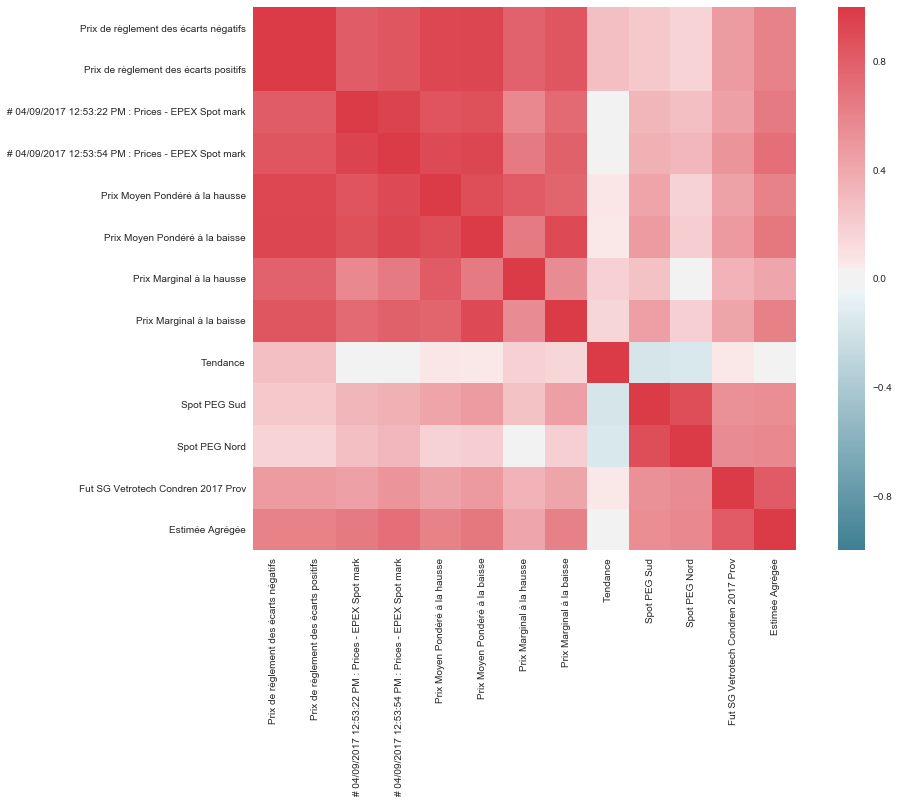

In [10]:
# calculate the correlation matrix
f, ax = plt.subplots(figsize=(15, 10))
corr = values_df.corr(method='pearson')

sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),square=True, ax=ax)
plt.show()

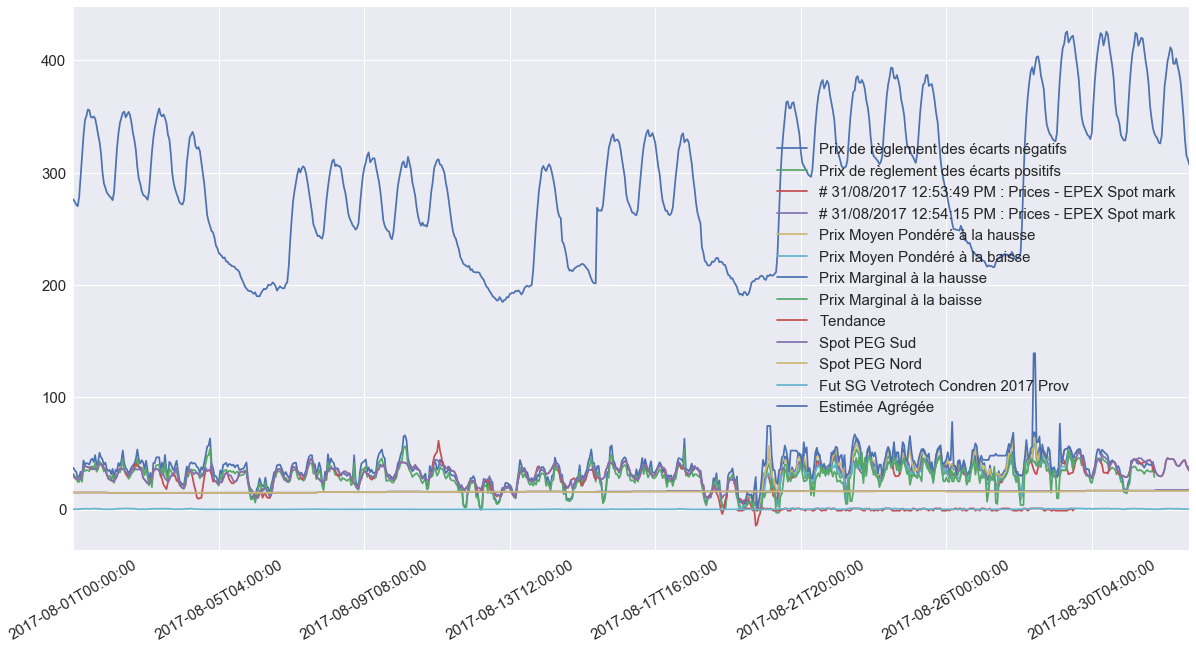

In [75]:
values_df.plot(figsize=(20,10),fontsize=15)
plt.xticks(rotation=30,fontsize=15)
plt.legend(fontsize=15)
plt.show()

# Very long to compute and need finite values
#sns.pairplot(values_df)
#plt.show()

In [76]:
'''CAN T WORK 
There is nans and infs in data....

from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca.fit(values_df)


from pandas.plotting import scatter_matrix
scatter_matrix(values_df, alpha=0.2, figsize=(6, 6), diagonal='kde')
'''


"CAN T WORK \nThere is nans and infs in data....\n\nfrom sklearn.decomposition import PCA\npca = PCA(n_components=5)\npca.fit(values_df)\n\n\nfrom pandas.plotting import scatter_matrix\nscatter_matrix(values_df, alpha=0.2, figsize=(6, 6), diagonal='kde')\n"

In [77]:
values_df.iloc[500]

Prix de règlement des écarts négatifs                  47.165000
Prix de règlement des écarts positifs                  40.175000
# 31/08/2017 12:53:49 PM : Prices - EPEX Spot mark     41.010000
# 31/08/2017 12:54:15 PM : Prices - EPEX Spot mark     41.010000
Prix Moyen Pondéré à la hausse                         43.670000
Prix Moyen Pondéré à la baisse                         41.010000
Prix Marginal à la hausse                              49.055000
Prix Marginal à la baisse                              41.010000
Tendance                                                0.000000
Spot PEG Sud                                           16.460000
Spot PEG Nord                                          16.230000
Fut SG Vetrotech Condren 2017 Prov                      0.266667
Estimée Agrégée                                       318.549337
Name: 2017-08-21T20:00:00, dtype: float64

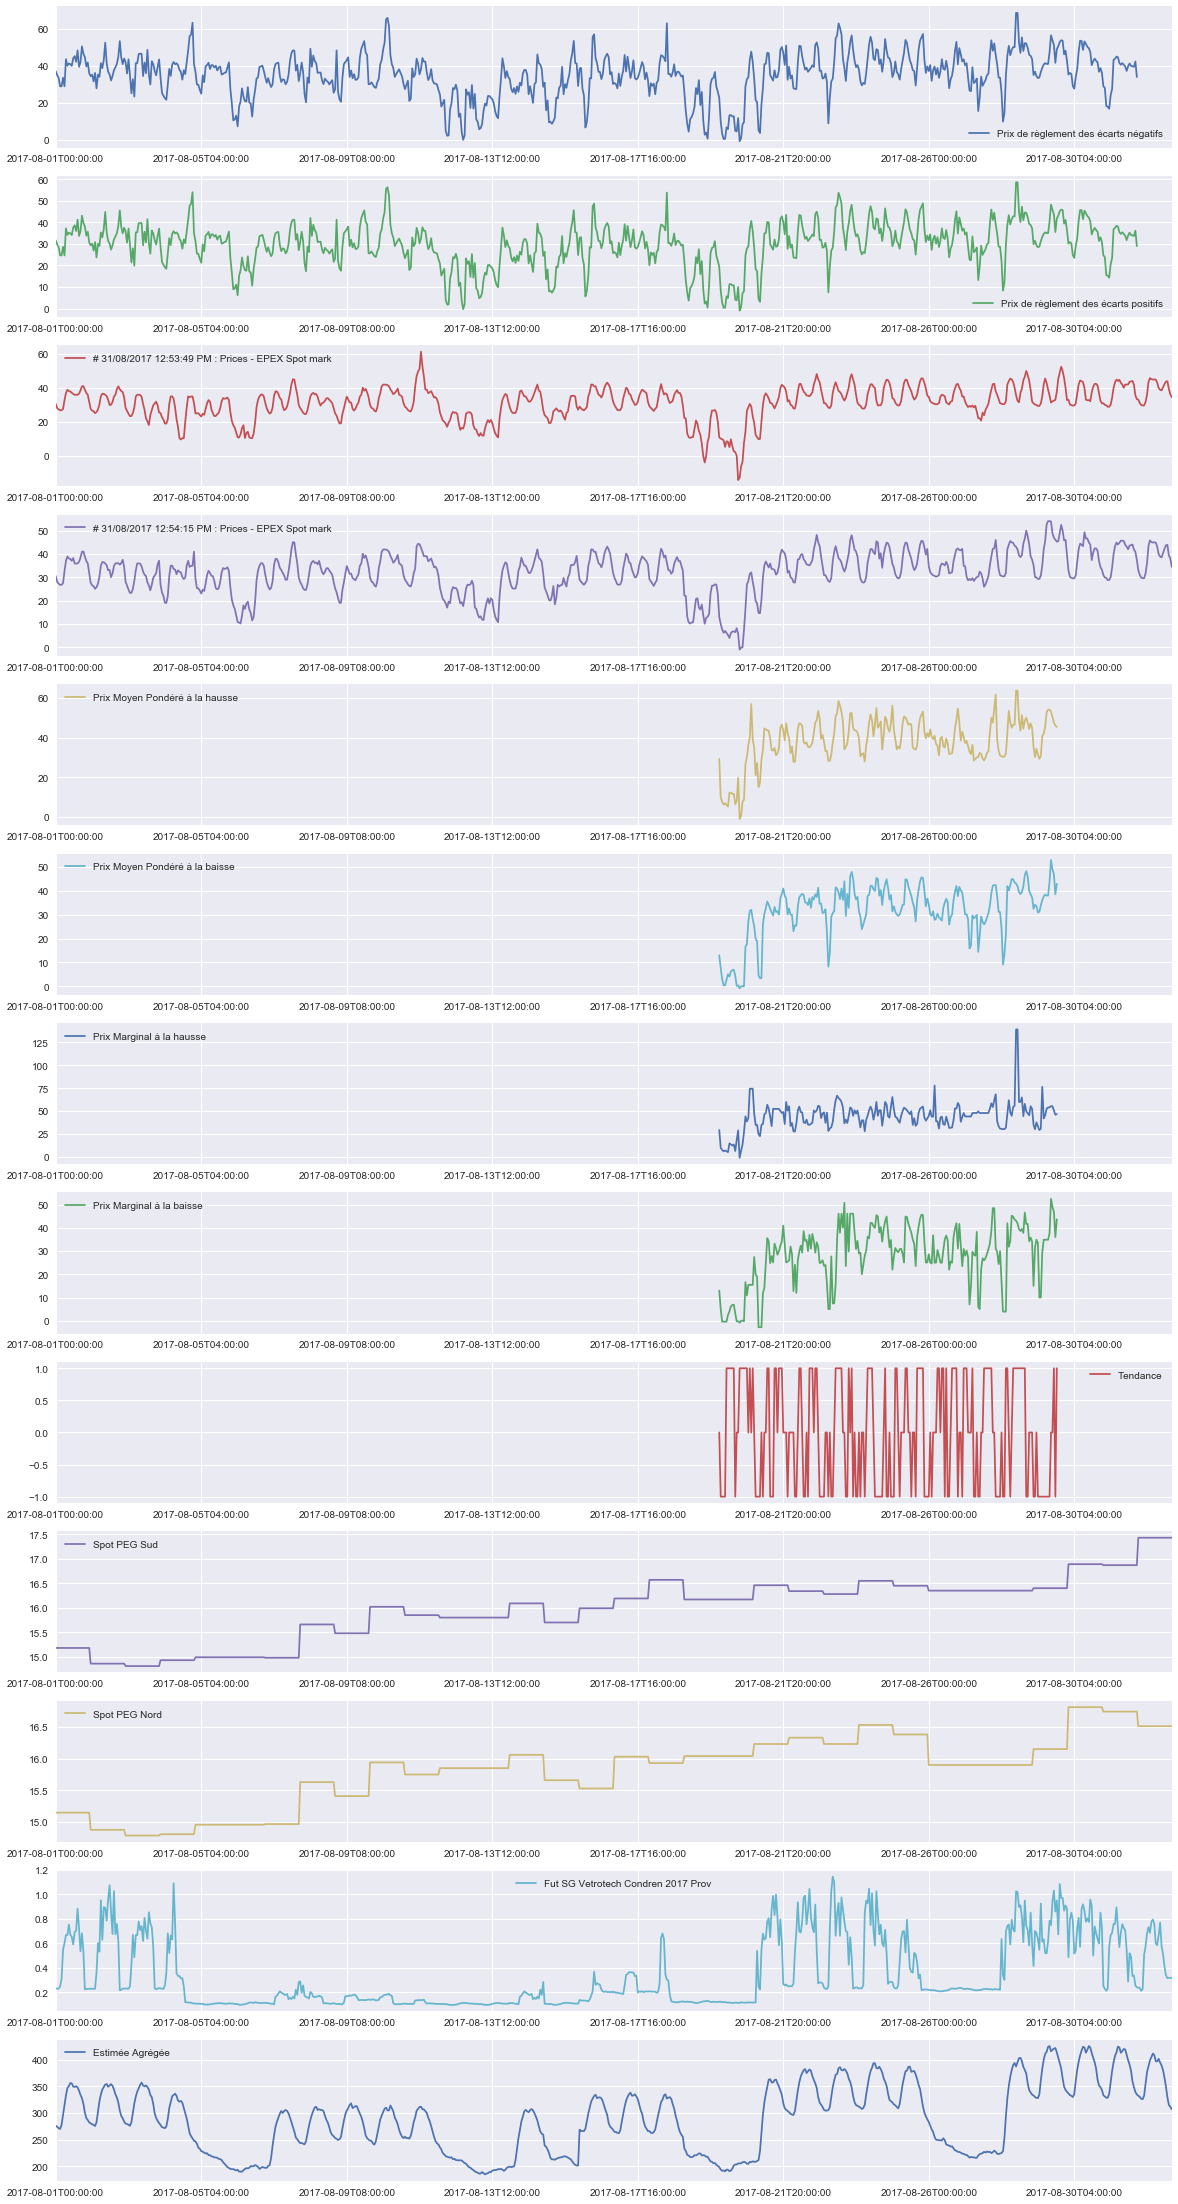

In [78]:
values_df.plot(subplots=True, layout=(values_df.shape[1], 1), figsize=(20,40), legend=True, sharex=False);
plt.show()

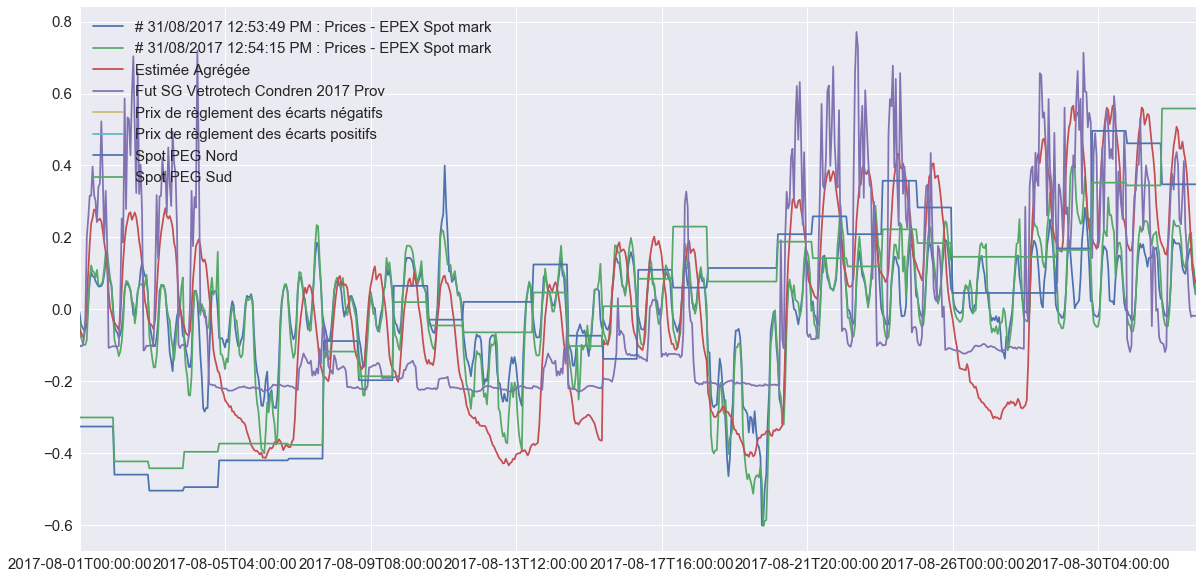

In [79]:
'''Normalization of each column of a pandas.dataframe
And Exclusion of certain columns'''
df_norm = (values_df - values_df.mean()) / (values_df.max() - values_df.min())
exclude = ['Prix Moyen Pondéré à la hausse', 'Prix Marginal à la hausse',
           'Prix Moyen Pondéré à la baisse', 'Prix Marginal à la baisse','Tendance']

df_norm.loc[:, df_norm.columns.difference(exclude)].plot(figsize=(20,10),fontsize=15)
plt.legend(fontsize=15)
plt.show()

In [80]:
print(df['Nom de courbe'].tolist())


['Prix de règlement des écarts négatifs', 'Prix de règlement des écarts positifs', 'Spot ELEC Germany', 'Spot ELEC France', 'Prix Moyen Pondéré à la hausse', 'Prix Moyen Pondéré à la baisse', 'Prix Marginal à la hausse', 'Prix Marginal à la baisse', 'Tendance', 'Spot GAZ PEGS', 'Spot GAZ PEGN', 'Fut SG Vetrotech Condren 2017 Prov', 'Estimée Agrégée']


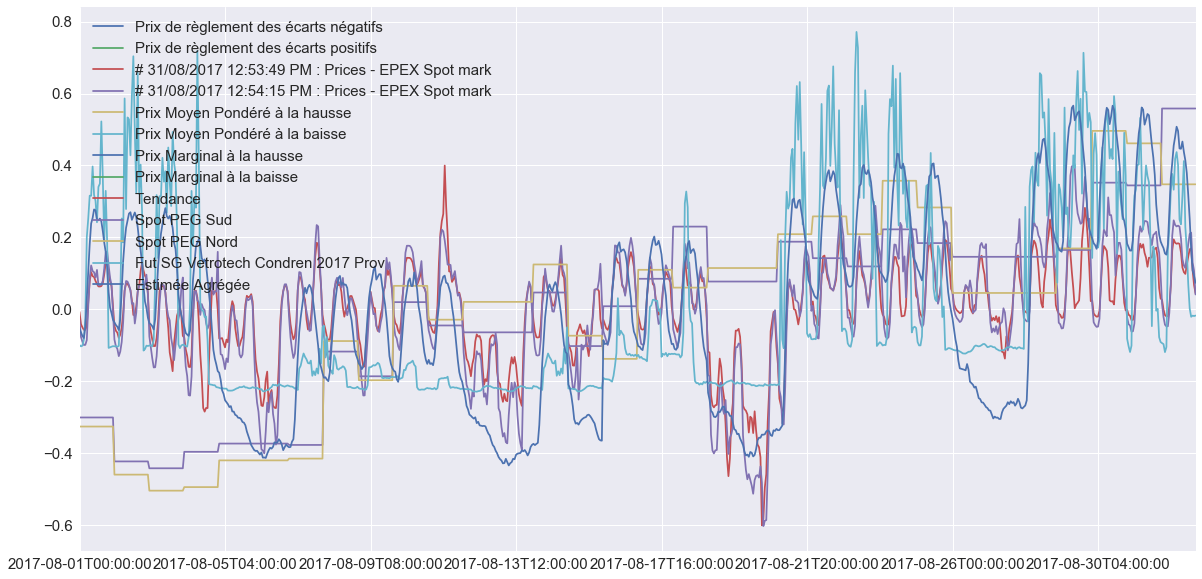

In [41]:
df_norm.plot(figsize=(20,10),fontsize=15)
plt.legend(fontsize=15)
plt.show()

In [81]:
payload


{'PfmPrev': '0',
 'apcType': '0',
 'avecChgtHeure': '0',
 'carId': '5',
 'crbId': 2416289,
 'debut': '2017-08-01',
 'fin': '2017-09-01',
 'pas': '1',
 'pdlId': '0',
 'startEnd': '0',
 'typeAppel': '1',
 'usrLogin': 'tran_r',
 'usrMdp': 'Salomonst21!'}

In [91]:
conf_dict = {}
md_text = '## Project Data to 3-D Principal Component Space (on sampled data)'

if len(df["Nom de courbe"].tolist()) > 3:
    export_filename = 'pca3d_report2.ipynb'
    w1, w2, w3, w4 = None, None, None, None
    w1 = widgets.Dropdown(
        options=df["Nom de courbe"].tolist(),
        value=df["Nom de courbe"].tolist()[0],
        description='Legend Variable:'
    )
    
    w2 = ipywidgets.IntSlider(min=-180, max=180, step=5, value=30, description='Angle')
    w_export = widgets.Button(description='Export',value='Export')
    handle_export_partial = partial(handle_export, w1=w1, w2=w2, w3=w3, \
                                    export_filename=export_filename, md_text=md_text)     
    w1.observe(handle_change,'value')
    w_export.on_click(handle_export_partial)
    
    i = interactive(InteractionAnalytics.pca_3d, df=fixed(df), conf_dict=fixed(conf_dict),\
                                              col1=w1, col2=w2, col3=fixed(w3),Export=w_export)

    hbox=widgets.HBox(i.children)
    display(hbox)
    hbox.on_displayed(InteractionAnalytics.pca_3d(df,conf_dict,col1=w1.value,col2=w2.value,Export=w_export))

ValueError: <ipywidgets.widgets.widget_button.Button object at 0x00000165A6888940> cannot be transformed to a widget

## <a name="show hide codes"></a>Show/Hide the Source Codes

In [43]:
# Provide the path to the yaml file relative to the working directory
display(HTML('''<style>
    .widget-label { min-width: 20ex !important; }
    .widget-text { min-width: 60ex !important; }
</style>'''))

#Toggle Code
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();

 } else {
 $('div.input').show();

 }
 code_show = !code_show
} 
//$( document ).ready(code_toggle);//commenting code disabling by default
</script>
<form action = "javascript:code_toggle()"><input type="submit" value="Toggle Raw Code"></form>''')

In [52]:
df["Nom de courbe"].tolist()[0]

'Prix de règlement des écarts négatifs'

In [13]:
pd.notnull(values_df)

,Prix de règlement des écarts négatifs,Prix de règlement des écarts positifs,# 04/09/2017 12:53:22 PM : Prices - EPEX Spot mark,# 04/09/2017 12:53:54 PM : Prices - EPEX Spot mark,Prix Moyen Pondéré à la hausse,Prix Moyen Pondéré à la baisse,Prix Marginal à la hausse,Prix Marginal à la baisse,Tendance,Spot PEG Sud,Spot PEG Nord,Fut SG Vetrotech Condren 2017 Prov,Estimée Agrégée
2017-08-05T00:00:00,True,True,True,True,True,True,True,True,True,True,True,True,True
2017-08-05T01:00:00,True,True,True,True,True,True,True,True,True,True,True,True,True
2017-08-05T02:00:00,True,True,True,True,True,True,True,True,True,True,True,True,True
2017-08-05T03:00:00,True,True,True,True,True,True,True,True,True,True,True,True,True
2017-08-05T04:00:00,True,True,True,True,True,True,True,True,True,True,True,True,True
2017-08-05T05:00:00,True,True,True,True,True,True,True,True,True,True,True,True,True
2017-08-05T06:00:00,True,True,True,True,True,True,True,True,True,True,True,True,True
2017-08-05T07:00:00,True,True,True,True,True,True,True,True,True,True,True,True,True
2017-08-05T08:00:00,True,True,True,True,True,True,True,True,True,True,True,True,True
2017-08-05T09:00:00,True,True,True,True,True,True,True,True,True,True,True,True,True


In [28]:
n= pd.Series(range(3), index=['b', 'e', 'f'])
print(n)

b    0
e    1
f    2
dtype: int32
